In [46]:
!pip install pmdarima
from pmdarima import auto_arima

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rohansirohia","key":"2c005421e079222405330ff20409a081"}'}

In [5]:
!pip install -q kaggle

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download rohanrao/nifty50-stock-market-data


 74% 13.0M/17.6M [00:00<00:00, 51.7MB/s]
100% 17.6M/17.6M [00:00<00:00, 69.6MB/s]


In [8]:
from zipfile import ZipFile
ob = ZipFile('nifty50-stock-market-data.zip')
ob.extractall()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [61]:
df = pd.read_csv('HDFCBANK.csv')

In [62]:
df.set_index("Date", drop=False, inplace=True)


In [63]:
df.tail(10)

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2020-05-15,2020-05-15,HDFCBANK,EQ,893.70,890.50,892.40,875.00,888.00,888.15,885.00,12174870,1.077480e+15,280499.0,4280446.0,0.3516
2020-05-18,2020-05-18,HDFCBANK,EQ,888.15,888.00,888.00,831.30,838.00,836.65,847.83,23326656,1.977695e+15,533951.0,10660724.0,0.4570
2020-05-19,2020-05-19,HDFCBANK,EQ,836.65,860.85,867.30,826.10,832.85,830.65,846.32,23730561,2.008377e+15,415550.0,8905443.0,0.3753
2020-05-20,2020-05-20,HDFCBANK,EQ,830.65,836.45,864.00,832.20,863.50,857.10,844.42,20007413,1.689474e+15,359835.0,8748975.0,0.4373
2020-05-21,2020-05-21,HDFCBANK,EQ,857.10,861.45,884.00,852.30,860.40,859.55,870.64,24239683,2.110407e+15,416994.0,10837256.0,0.4471
2020-05-22,2020-05-22,HDFCBANK,EQ,859.55,850.00,870.30,833.05,842.65,838.85,844.52,21025849,1.775681e+15,382888.0,5893652.0,0.2803
2020-05-26,2020-05-26,HDFCBANK,EQ,838.85,857.00,871.75,848.75,858.00,852.40,860.62,19002589,1.635402e+15,303415.0,7852814.0,0.4132
2020-05-27,2020-05-27,HDFCBANK,EQ,852.40,859.90,909.80,857.15,901.40,903.65,881.85,28013227,2.470358e+15,388895.0,11070917.0,0.3952
2020-05-28,2020-05-28,HDFCBANK,EQ,903.65,920.00,950.00,913.95,947.50,945.25,938.36,37744926,3.541845e+15,631552.0,15665889.0,0.4150


In [64]:
df['Date'] = pd.to_datetime(df['Date'])

In [65]:
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]

win3, win7, win30 = 3,7,30


In [66]:
#df.VWAP.tail(100).plot(figsize=(10,10))
#plt.grid(True)

df_rolled_3d = df[lag_features].rolling(window=win3, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=win7, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=win30, min_periods=0)



df_mean_3d = df_rolled_3d.mean().shift(1).astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).astype(np.float32)

#df_std_30d.plot(figsize=(10,10))


for feature in lag_features:
    df[f"{feature}_mean_lag{win3}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{win7}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{win30}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{win3}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{win7}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{win30}"] = df_std_30d[feature]


df.fillna(df.mean(), inplace=True)
df.set_index("Date", drop=False, inplace=True)
df.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-22,2020-05-22,HDFCBANK,EQ,859.55,850.0,870.30,833.05,842.65,838.85,844.52,21025849,1.775681e+15,382888.0,5893652.0,0.2803,871.766663,895.242859,933.340027,10.722095,32.623196,34.955719,836.866638,861.285706,894.311646,13.709243,35.997379,38.313305,22659220.0,20775740.0,20553228.0,2310596.75,4178373.00,6202577.5,1.936086e+15,1.817698e+15,1.870241e+15,2.195808e+14,3.611859e+14,5.555840e+14,397459.65625,395285.71875,381707.37500,32591.916016,76942.398438,101612.656250
2020-05-26,2020-05-26,HDFCBANK,EQ,838.85,857.0,871.75,848.75,858.00,852.40,860.62,19002589,1.635402e+15,303415.0,7852814.0,0.4132,872.766663,882.428589,932.106689,10.225621,16.657602,36.523727,839.183350,848.564270,893.901672,11.367314,24.969660,38.916389,21757648.0,20611782.0,20247202.0,2208998.75,4136691.50,5930379.5,1.858521e+15,1.774095e+15,1.841673e+15,2.223581e+14,3.420314e+14,5.367398e+14,386572.34375,393391.43750,378630.37500,28757.060547,77080.734375,100069.921875
2020-05-27,2020-05-27,HDFCBANK,EQ,852.40,859.9,909.80,857.15,901.40,903.65,881.85,28013227,2.470358e+15,388895.0,11070917.0,0.3952,875.349976,876.821411,929.664978,7.526121,11.124143,38.048668,844.700012,842.671448,893.323303,10.244144,17.228558,39.468792,21422708.0,20501088.0,19943626.0,2641005.50,4172947.00,5744188.5,1.840497e+15,1.753502e+15,1.811661e+15,2.440457e+14,3.459650e+14,5.215484e+14,367765.65625,384733.15625,371976.90625,58280.023438,84020.960938,98131.242188
2020-05-28,2020-05-28,HDFCBANK,EQ,903.65,920.0,950.00,913.95,947.50,945.25,938.36,37744926,3.541845e+15,631552.0,15665889.0,0.4150,883.950012,879.307129,928.961670,22.398493,16.042248,38.219685,846.316650,840.121399,892.228333,12.232880,12.246865,40.016064,22680556.0,22763712.0,20136434.0,4727731.00,3048250.75,5917990.0,1.960481e+15,1.952485e+15,1.826328e+15,4.471029e+14,2.880589e+14,5.339499e+14,358399.34375,400218.28125,371009.71875,47712.457031,70511.421875,97805.359375
2020-05-29,2020-05-29,HDFCBANK,EQ,945.25,944.0,955.00,923.45,947.10,951.65,937.44,26512600,2.485397e+15,352639.0,10530145.0,0.3972,910.516663,888.164307,929.071655,39.129921,31.403008,38.277203,873.283325,851.928589,893.153320,35.467918,29.712215,40.192253,28253580.0,24823464.0,20825288.0,9373480.00,6457203.00,6700830.0,2.549202e+15,2.175935e+15,1.892707e+15,9.556636e+14,6.675562e+14,6.159572e+14,441287.34375,414161.28125,379089.87500,170226.875000,103361.148438,108755.562500


In [67]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,HDFCBANK,EQ,157.40,166.00,170.00,166.00,170.00,170.00,169.52,33259,5.638122e+11,66527.159101,1.062489e+06,0.603802,1007.148315,1006.866577,1005.181213,11.310165,17.871513,39.045536,981.329834,981.059814,979.431702,11.595297,18.211773,39.399689,1.619865e+06,1.610543e+06,1.567187e+06,548848.625000,675456.312500,876143.312500,1.843575e+14,1.835394e+14,1.796116e+14,6.434157e+13,7.962755e+13,1.033992e+14,66165.625,65843.203125,64076.777344,16987.296875,20617.759766,25384.982422,1,1,3,0
2000-01-04,2000-01-04,HDFCBANK,EQ,170.00,182.00,183.45,171.00,174.00,173.80,174.99,168710,2.952261e+12,66527.159101,1.062489e+06,0.603802,170.000000,170.000000,170.000000,11.310165,17.871513,39.045536,166.000000,166.000000,166.000000,11.595297,18.211773,39.399689,3.325900e+04,3.325900e+04,3.325900e+04,548848.625000,675456.312500,876143.312500,5.638122e+11,5.638122e+11,5.638122e+11,6.434157e+13,7.962755e+13,1.033992e+14,66165.625,65843.203125,64076.777344,16987.296875,20617.759766,25384.982422,1,1,4,1
2000-01-05,2000-01-05,HDFCBANK,EQ,173.80,170.00,173.90,165.00,168.00,166.95,169.20,159820,2.704094e+12,66527.159101,1.062489e+06,0.603802,176.725006,176.725006,176.725006,9.510586,9.510586,9.510586,168.500000,168.500000,168.500000,3.535534,3.535534,3.535534,1.009845e+05,1.009845e+05,1.009845e+05,95778.320312,95778.320312,95778.320312,1.758037e+12,1.758037e+12,1.758037e+12,1.688889e+12,1.688889e+12,1.688889e+12,66165.625,65843.203125,64076.777344,16987.296875,20617.759766,25384.982422,1,1,5,2
2000-01-06,2000-01-06,HDFCBANK,EQ,166.95,168.00,170.00,165.30,168.95,168.30,168.44,85026,1.432166e+12,66527.159101,1.062489e+06,0.603802,175.783340,175.783340,175.783340,6.919959,6.919959,6.919959,167.333328,167.333328,167.333328,3.214550,3.214550,3.214550,1.205963e+05,1.205963e+05,1.205963e+05,75766.851562,75766.851562,75766.851562,2.073389e+12,2.073389e+12,2.073389e+12,1.313207e+12,1.313207e+12,1.313207e+12,66165.625,65843.203125,64076.777344,16987.296875,20617.759766,25384.982422,1,1,6,3
2000-01-07,2000-01-07,HDFCBANK,EQ,168.30,162.15,171.00,162.15,170.75,168.35,166.79,85144,1.420158e+12,66527.159101,1.062489e+06,0.603802,175.783340,174.337494,174.337494,6.919959,6.347096,6.347096,167.100006,166.824997,166.824997,3.380828,2.814694,2.814694,1.378520e+05,1.117038e+05,1.117038e+05,45964.089844,64369.164062,64369.164062,2.362840e+12,1.913083e+12,1.913083e+12,8.154833e+11,1.119137e+12,1.119137e+12,66165.625,65843.203125,64076.777344,16987.296875,20617.759766,25384.982422,1,1,7,4


In [68]:
exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]


df_train = df[df.Date < "2020"]
df_valid = df[df.Date >= "2020"]

In [69]:
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=51028.798, BIC=51289.277, Time=21.770 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=51631.993, BIC=51866.424, Time=17.188 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=51115.337, BIC=51356.281, Time=17.668 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=51039.487, BIC=51280.430, Time=18.337 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=88995.601, BIC=89223.520, Time=16.710 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=51044.921, BIC=51298.889, Time=21.332 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=51030.705, BIC=51284.672, Time=19.434 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=51028.062, BIC=51295.053, Time=22.402 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=51034.108, BIC=51294.588, Time=21.803 seconds
Fit ARIMA(4,0,2)x(0,0,0,0) [intercept=True]; AIC=51029.782, BIC=51303.286, Time=23.159 seconds
Fit AR

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


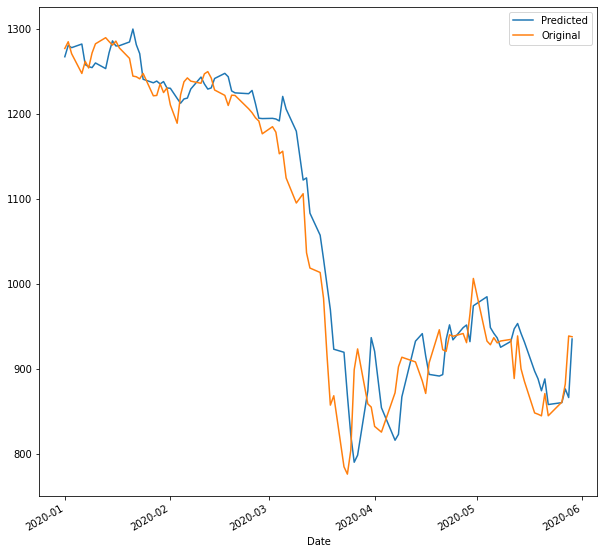

In [70]:
df_valid.Forecast_ARIMAX.plot(figsize = (10,10), label = 'Predicted')
df[df.index >= "2020"].VWAP.plot(figsize = (10,10), label = 'Original')
plt.legend()
plt.show()

In [71]:
from sklearn.metrics import mean_squared_error as mse
